## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import os
from keras import regularizers

## Link to dataset

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset

In [2]:
from pathlib import Path
curr_path = os.getcwd()
crr_path = Path(curr_path)
parent_path = crr_path.parent
path = str(parent_path) +  '\\data\\Actor_01\\'
mylist= os.listdir(path)

## Plotting the audio file's waveform and its spectrogram for one sample audio track

In [3]:
data, sampling_rate = librosa.load(path + '03-02-01-01-01-01-01.wav')

In [4]:
import IPython
IPython.display.Audio(data=data, rate=sampling_rate)

Populating the interactive namespace from numpy and matplotlib


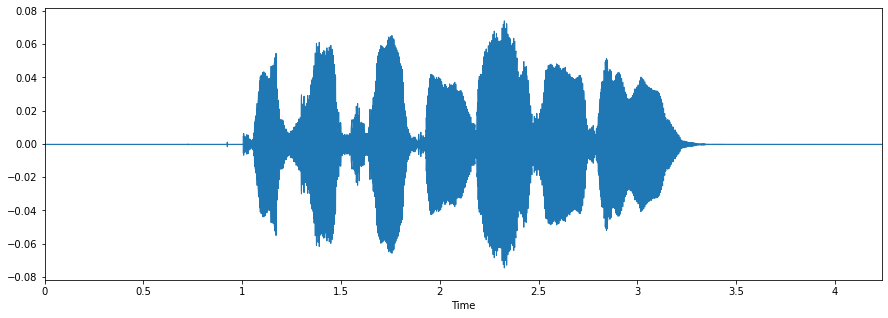

In [5]:
%pylab inline
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

d:\inhouseprojects\esa\model_training\aser_env\lib\site-packages\ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
d:\inhouseprojects\esa\model_training\aser_env\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


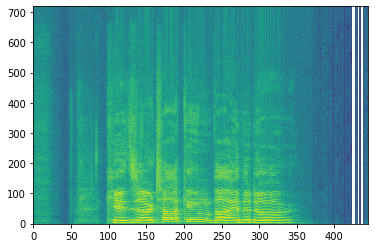

In [6]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read(path+'03-02-03-01-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [7]:
feeling_list=[]
#for item in mylist:
#    if item[6:-16]=='03':
#        feeling_list.append('Happy')
#    elif item[6:-16]=='05':
#        feeling_list.append('Angry')
        
# (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).        
        
feeling_list=[]
for item in mylist:
    if item[6:-16]=='01':
        feeling_list.append('neutral')
    if item[6:-16]=='02':
        feeling_list.append('calm')
    elif item[6:-16]=='03':
        feeling_list.append('Happy')
    elif item[6:-16]=='04':
        feeling_list.append('sad')
    elif item[6:-16]=='05':
        feeling_list.append('angry')
    elif item[6:-16]=='06':
        feeling_list.append('fearful')
    elif item[6:-16]=='07': 
        feeling_list.append('disgust')
    elif item[6:-16]=='08': 
        feeling_list.append('surprised')
   

In [8]:
labels = pd.DataFrame(feeling_list)

In [9]:
labels[:10]

,0
0,neutral
1,neutral
2,neutral
3,neutral
4,neutral
5,neutral
6,neutral
7,neutral
8,calm
9,calm


## Getting the features of audio files using librosa

In [10]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    X, sample_rate = librosa.load(path+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),
                        axis=0)
    feature = mfccs
    #[float(i) for i in feature]
    df.loc[bookmark] = [feature]
    bookmark=bookmark+1    

In [11]:
#df = pd.DataFrame(columns=['feature'])
#bookmark=0
#for index,y in enumerate(mylist):
#    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
#        X, sample_rate = librosa.load(path+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
#        sample_rate = np.array(sample_rate)
#        mfccs = np.mean(librosa.feature.mfcc(y=X, 
#                                            sr=sample_rate, 
#                                            n_mfcc=13),
#                        axis=0)
#        feature = mfccs
#        #[float(i) for i in feature]
#        df.loc[bookmark] = [feature]
#        bookmark=bookmark+1        

In [12]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [13]:
newdf = pd.concat([df3,labels], axis=1)

In [14]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [15]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,-61.437893,...,-32.945343,-33.176186,-34.265820,-35.032082,-35.226254,-33.980114,-33.823757,-26.193581,-23.175070,neutral
49,-44.759438,-44.764263,-44.764263,-44.855537,-44.773396,-44.806221,-44.867943,-44.867397,-44.616856,-44.362431,...,-33.057480,-35.105190,-35.690922,-36.678986,-36.814781,-35.020035,-31.468943,-25.559795,-18.903685,sad
71,-47.936638,-47.936638,-47.936638,-47.936638,-47.936638,-47.936638,-47.936638,-47.936638,-47.936638,-47.936638,...,-31.630489,-30.419844,-28.925341,-28.079071,-25.401485,-28.253855,-28.757969,-25.036448,-21.603617,angry
11,-58.917778,-58.917778,-58.917778,-58.917778,-58.917778,-58.917778,-58.524311,-58.344727,-57.648758,-58.135777,...,-45.620155,-46.545307,-46.995953,-48.813625,-48.057186,-47.746513,-48.875584,-22.981894,-14.089889,calm
37,-47.141750,-47.141750,-47.141750,-47.141750,-47.141750,-47.141750,-47.141750,-47.141750,-47.141750,-47.141750,...,-39.181122,-39.666824,-39.918831,-39.222023,-39.457462,-38.702858,-38.153938,-25.546980,-17.472002,Happy
72,-57.906776,-57.906776,-57.906776,-57.906776,-57.906776,-57.906776,-57.906776,-57.906776,-57.995979,-58.301846,...,-25.764357,-28.052029,-28.587877,-29.994150,-29.487801,-28.748426,-27.663626,-19.329582,-14.170835,fearful
21,-54.892918,-53.860718,-53.629765,-54.054070,-54.340000,-54.348885,-54.532963,-54.647217,-54.305691,-53.999302,...,-36.496315,-37.835114,-41.446720,-40.914452,-37.755550,-38.136387,-39.681660,-29.014799,-21.230534,calm
63,-50.450321,-50.450321,-50.450321,-50.450321,-50.450321,-50.450321,-50.446453,-50.450321,-50.450321,-50.698948,...,-42.689796,-40.884151,-39.857815,-39.666897,-40.094013,-40.097488,-40.380783,-22.306007,-13.826655,angry
53,-50.286125,-49.724319,-49.976723,-50.427464,-50.694893,-48.572475,-48.053596,-48.341267,-48.119289,-47.071026,...,-42.149273,-43.022461,-43.518208,-43.952427,-44.830360,-43.096123,-43.148464,-26.333191,-18.607349,sad
45,-55.576317,-55.576317,-55.576317,-54.659672,-54.034431,-54.494568,-54.857063,-54.399475,-53.959286,-53.900295,...,-39.122200,-36.716236,-40.453377,-40.219475,-41.346844,-42.880005,-44.229630,-27.269268,-20.113741,sad


In [16]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [17]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [18]:
train[10:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
43,-57.077591,-57.077591,-57.077591,-57.184799,-57.127621,-56.868759,-56.899265,-56.883583,-56.114353,-55.602165,...,-39.639870,-40.429783,-39.922707,-38.340855,-38.624313,-41.267395,-39.687405,-27.108532,-19.301563,sad
87,-44.969242,-44.969242,-44.969242,-44.969242,-44.969242,-44.969242,-44.969242,-44.969242,-44.969242,-44.969242,...,-31.138828,-32.527855,-35.770565,-36.143757,-38.934181,-39.019447,-39.909714,-21.394440,-12.477627,fearful
46,-59.498558,-59.498558,-59.498558,-59.498558,-59.498558,-59.498558,-59.498558,-59.498558,-59.498558,-59.498558,...,-27.103651,-26.713259,-27.032917,-26.008802,-26.594187,-30.178743,-29.229483,-23.479540,-19.037220,sad
80,-51.925014,-50.482735,-50.104336,-51.994728,-53.954281,-53.447403,-51.927692,-51.877956,-53.078091,-53.253517,...,-26.198635,-28.088930,-28.383026,-29.718781,-28.278400,-29.305759,-31.019484,-22.433128,-18.039310,fearful
41,-54.081699,-54.081699,-54.081699,-54.081699,-54.066475,-54.166428,-54.057064,-53.987667,-53.773357,-54.051052,...,-41.385036,-40.656166,-40.692204,-40.932720,-40.317043,-42.101048,-45.648888,-25.297276,-17.306187,sad
28,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,...,-30.747688,-31.649845,-31.559135,-33.048920,-32.931534,-33.156113,-32.168266,-21.888123,-17.059032,Happy
47,-53.428711,-53.148766,-53.129154,-53.444176,-53.293861,-53.180119,-53.648369,-53.928276,-53.830204,-53.115963,...,-44.433250,-46.226601,-46.219143,-44.036751,-42.809509,-44.782169,-47.049595,-28.186108,-20.102812,sad
16,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-25.822012,-26.811409,-28.635288,-30.002087,-32.346752,-34.095303,-34.079765,-23.301121,-17.947985,calm
86,-39.908321,-42.552586,-45.834164,-44.702881,-46.018230,-48.073006,-48.853680,-48.763035,-48.455200,-48.683464,...,-25.525604,-25.658501,-26.874594,-27.624981,-28.162413,-28.979378,-28.717476,-18.847151,-12.962069,fearful
76,-57.544453,-57.544453,-57.544453,-57.544453,-57.544453,-57.544453,-57.544453,-57.544453,-57.544453,-57.544453,...,-29.005177,-28.504738,-28.910458,-29.691343,-30.419102,-29.777998,-29.215740,-20.959085,-15.820024,fearful


In [19]:
trainfeatures = train.iloc[:, :-1]

In [20]:
trainlabel = train.iloc[:, -1:]
print(shape(trainlabel))

(68, 1)


In [21]:
testfeatures = test.iloc[:, :-1]

In [22]:
testlabel = test.iloc[:, -1:]

In [23]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

nb_classes = 8 
encoder = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train), nb_classes)
y_test = np_utils.to_categorical(lb.fit_transform(y_test), nb_classes)

numpy.save('encoder.npy', lb.classes_)

d:\inhouseprojects\esa\model_training\aser_env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [24]:
y_train

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 

In [25]:
y_test

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [26]:
X_train.shape

(68, 216)

## Changing dimension for CNN model

In [27]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [28]:
model = Sequential()
#filters, kernel_size, strides=1, padding='valid', data_format='channels_last',

model.add(Conv1D(256, 5,padding='same', input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax')) #softmax as we are doing multiclass classification
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

In [32]:
model.compile(loss=
             'categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
#tf.keras.losses.SparseCategoricalCrossentropy()
#'categorical_crossentropy'

In [33]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
5/5 [==============================] - 0s 75ms/step - loss: 2.1627 - accuracy: 0.1765 - val_loss: 1.9972 - val_accuracy: 0.1000
Epoch 2/200
5/5 [==============================] - 0s 37ms/step - loss: 1.9694 - accuracy: 0.2353 - val_loss: 1.7622 - val_accuracy: 0.1000
Epoch 3/200
5/5 [==============================] - 0s 34ms/step - loss: 1.8010 - accuracy: 0.2500 - val_loss: 2.0398 - val_accuracy: 0.0500
Epoch 4/200
5/5 [==============================] - 0s 35ms/step - loss: 1.7888 - accuracy: 0.2206 - val_loss: 1.8458 - val_accuracy: 0.2500
Epoch 5/200
5/5 [==============================] - 0s 43ms/step - loss: 1.8114 - accuracy: 0.2059 - val_loss: 1.7932 - val_accuracy: 0.2000
Epoch 6/200
5/5 [==============================] - 0s 34ms/step - loss: 1.6824 - accuracy: 0.2794 - val_loss: 1.7982 - val_accuracy: 0.1000
Epoch 7/200
5/5 [==============================] - 0s 34ms/step - loss: 1.7290 - accuracy: 0.3235 - val_loss: 1.8871 - val_accuracy: 0.1000
Epoch 8/200
5/5 [===

5/5 [==============================] - 0s 39ms/step - loss: 0.9272 - accuracy: 0.7206 - val_loss: 1.5098 - val_accuracy: 0.4000
Epoch 60/200
5/5 [==============================] - 0s 35ms/step - loss: 0.9003 - accuracy: 0.7794 - val_loss: 1.4781 - val_accuracy: 0.3500
Epoch 61/200
5/5 [==============================] - 0s 36ms/step - loss: 0.8627 - accuracy: 0.7353 - val_loss: 1.5320 - val_accuracy: 0.3500
Epoch 62/200
5/5 [==============================] - 0s 35ms/step - loss: 0.8349 - accuracy: 0.8382 - val_loss: 1.4786 - val_accuracy: 0.3500
Epoch 63/200
5/5 [==============================] - 0s 42ms/step - loss: 0.8093 - accuracy: 0.8235 - val_loss: 1.5707 - val_accuracy: 0.3500
Epoch 64/200
5/5 [==============================] - 0s 41ms/step - loss: 0.8214 - accuracy: 0.7353 - val_loss: 1.4570 - val_accuracy: 0.3500
Epoch 65/200
5/5 [==============================] - 0s 40ms/step - loss: 0.7814 - accuracy: 0.7941 - val_loss: 1.5461 - val_accuracy: 0.4000
Epoch 66/200
5/5 [========

5/5 [==============================] - 0s 37ms/step - loss: 0.2129 - accuracy: 0.9706 - val_loss: 1.5039 - val_accuracy: 0.3500
Epoch 118/200
5/5 [==============================] - 0s 35ms/step - loss: 0.1898 - accuracy: 1.0000 - val_loss: 1.5299 - val_accuracy: 0.3500
Epoch 119/200
5/5 [==============================] - 0s 36ms/step - loss: 0.1880 - accuracy: 0.9853 - val_loss: 1.5245 - val_accuracy: 0.4000
Epoch 120/200
5/5 [==============================] - 0s 33ms/step - loss: 0.1909 - accuracy: 0.9853 - val_loss: 1.5713 - val_accuracy: 0.3500
Epoch 121/200
5/5 [==============================] - 0s 32ms/step - loss: 0.1621 - accuracy: 1.0000 - val_loss: 1.5109 - val_accuracy: 0.4000
Epoch 122/200
5/5 [==============================] - 0s 36ms/step - loss: 0.1865 - accuracy: 0.9853 - val_loss: 1.5662 - val_accuracy: 0.3500
Epoch 123/200
5/5 [==============================] - 0s 32ms/step - loss: 0.1611 - accuracy: 1.0000 - val_loss: 1.5933 - val_accuracy: 0.3500
Epoch 124/200
5/5 [=

Epoch 175/200
5/5 [==============================] - 0s 34ms/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 1.6206 - val_accuracy: 0.4500
Epoch 176/200
5/5 [==============================] - 0s 35ms/step - loss: 0.0306 - accuracy: 1.0000 - val_loss: 1.6227 - val_accuracy: 0.4000
Epoch 177/200
5/5 [==============================] - 0s 38ms/step - loss: 0.0319 - accuracy: 1.0000 - val_loss: 1.6613 - val_accuracy: 0.4500
Epoch 178/200
5/5 [==============================] - 0s 41ms/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 1.6767 - val_accuracy: 0.4500
Epoch 179/200
5/5 [==============================] - 0s 40ms/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 1.6940 - val_accuracy: 0.4500
Epoch 180/200
5/5 [==============================] - 0s 36ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 1.6488 - val_accuracy: 0.4500
Epoch 181/200
5/5 [==============================] - 0s 33ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 1.6210 - val_accuracy: 0.4500
Epoch 

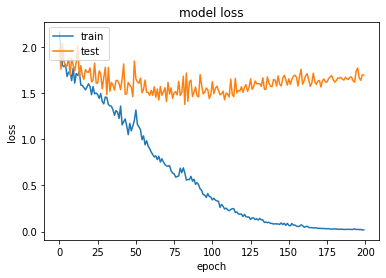

In [34]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [35]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\InhouseProjects\ESA\model_training\git\audio-sentiment-analysis\prototypes\saved_models\Emotion_Voice_Detection_Model.h5 


In [36]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [37]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 45.00%


## Predicting emotions on the test data

In [38]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 998us/step


In [39]:
preds

array([[2.33068854e-01, 7.68481009e-03, 6.71960533e-01, 2.09247286e-04,
        8.50413144e-02, 2.03524111e-03, 6.10802365e-19, 8.44833376e-22],
       [3.05228233e-01, 7.88376033e-02, 2.31768176e-01, 1.79002006e-02,
        3.28064293e-01, 3.82014811e-02, 2.04926304e-18, 1.10872834e-20],
       [5.67266671e-03, 8.86071622e-02, 2.07793519e-01, 3.22054595e-01,
        4.97194892e-03, 3.70900124e-01, 2.67636026e-15, 1.22282886e-15],
       [3.97911780e-02, 3.20955336e-01, 5.96247971e-01, 2.85892095e-02,
        4.23422636e-04, 1.39929019e-02, 1.22192309e-13, 6.82054185e-13],
       [3.53074050e-08, 6.35124650e-07, 9.92078722e-01, 2.07125256e-03,
        3.02897170e-05, 5.81897376e-03, 4.82338147e-16, 8.45890247e-17],
       [6.79025233e-01, 9.17349535e-04, 8.25385087e-06, 4.99748450e-04,
        3.15857381e-01, 3.69203510e-03, 1.37923855e-17, 1.22643944e-17],
       [1.58935227e-02, 2.43635677e-05, 8.00666749e-01, 4.61664516e-04,
        1.59420207e-01, 2.35334635e-02, 1.17345362e-18, 1.

In [40]:
preds1=preds.argmax(axis=1)

In [41]:
preds1

array([2, 4, 5, 2, 2, 0, 2, 0, 3, 5, 5, 1, 3, 1, 5, 2, 0, 0, 5, 2],
      dtype=int64)

In [42]:
abc = preds1.astype(int).flatten()

In [43]:
predictions = (lb.inverse_transform((abc)))

In [44]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf

,predictedvalues
0,calm
1,neutral
2,sad
3,calm
4,calm
5,Happy
6,calm
7,Happy
8,fearful
9,sad


In [45]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [46]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf

,actualvalues
0,calm
1,sad
2,calm
3,angry
4,calm
5,neutral
6,neutral
7,Happy
8,fearful
9,Happy


In [47]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [48]:
finaldf[0:4]

,actualvalues,predictedvalues
0,calm,calm
1,sad,neutral
2,calm,sad
3,angry,calm


In [49]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
Happy,6
angry,4
calm,5
fearful,2
neutral,2
sad,1


In [50]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
Happy,4
angry,2
calm,6
fearful,2
neutral,1
sad,5


In [51]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

## you could find this track on below link:

https://tuenl.sharepoint.com/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/Forms/AllItems.aspx?viewid=235c9f56%2Db4dc%2D418e%2D8800%2Dd0cde58fff30&id=%2Fsites%2Fgad%5Fcbo%2FJPC%2FMC%2FESA%20PDEng%20ST%20Project%2FModelsAndData%2FAudio%2FDevelopment%2Fdata%2Ftone%5Fcnn%5Fhappy%5Fangry%5Fdataset%5Fsample%5Fprediction%5Ftracks

In [58]:
data, sampling_rate = librosa.load(str(parent_path) + '\\data\\output10.wav')

Populating the interactive namespace from numpy and matplotlib


d:\inhouseprojects\esa\model_training\aser_env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


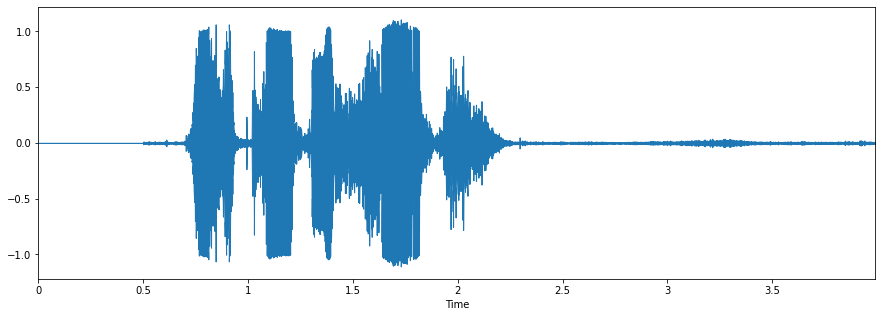

In [59]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [72]:
X, sample_rate = librosa.load(str(parent_path) +'\\data\\03-02-01-01-01-01-12.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [73]:
livedf2= pd.DataFrame(data=livedf2)

In [74]:
livedf2 = livedf2.stack().to_frame().T

In [75]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-54.301109,-54.301109,-54.301109,-54.301109,-54.301109,-54.301109,-54.301109,-54.301109,-54.301109,-54.301109,...,-45.028465,-42.86227,-42.461754,-44.024803,-44.932232,-42.350788,-41.971321,-43.120155,-36.827816,-29.464413


In [76]:
twodim= np.expand_dims(livedf2, axis=2)

In [77]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 2ms/step


In [78]:
livepreds

array([[4.2813455e-04, 4.1514072e-06, 4.2277414e-02, 1.5046274e-04,
        9.3983507e-01, 1.7304750e-02, 2.3175799e-19, 3.2582606e-22]],
      dtype=float32)

In [79]:
livepreds1=livepreds.argmax(axis=1)

In [80]:
liveabc = livepreds1.astype(int).flatten()

In [81]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['neutral'], dtype=object)